In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Module scripts
from toss import compute_trajectory
from toss import compute_motion, setup_spin_axis, rotate_point
from toss import get_trajectory_fixed_step
from toss import FitnessFunctions
from toss import get_fitness
from toss import create_mesh
from toss import setup_parameters
from toss import plot_UDP_3D, plot_UDP_2D, fitness_over_generations, fitness_over_time, distance_deviation_over_time
from toss import compute_space_coverage, create_spherical_tensor_grid

# Core packages
from dotmap import DotMap
import numpy as np
from math import pi
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import quaternion


Using numpy backend
/home/rasmus/mambaforge/envs/toss/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [218]:
args = setup_parameters()
args.problem.final_time = 604800
args.problem.number_of_spacecrafts = 4
args.problem.number_of_maneuvers = 4

# Prepare rotations assuming fixed measurment period and spin velocity:
measurement_times = list(np.arange(args.problem.start_time, args.problem.final_time, args.problem.measurement_period))*args.problem.number_of_spacecrafts
measurement_angles = -args.body.spin_velocity*np.asarray(measurement_times)
args.body.quaternion_rotation_objects = np.array([quaternion.from_rotation_vector(angle * args.body.spin_axis) for angle in measurement_angles])


In [197]:
print(args.body.quaternion_rotation_objects.shape)

(6048,)


In [225]:
# Concatenate initial position with chromosomes
x = np.genfromtxt('Local_new_gaco_param_4S_4M_champion_x.csv', delimiter=',')
#chromosomes = np.array_split(x, args.problem.number_of_spacecrafts)

if args.problem.number_of_spacecrafts == 1:
    chromosomes = x
else: 
    chromosomes = np.array_split(x, args.problem.number_of_spacecrafts)

initial_conditions = np.array_split([-135.13402075, -4089.53592604, 6050.17636635]*args.problem.number_of_spacecrafts, args.problem.number_of_spacecrafts)

if len(initial_conditions) == 0:
    list_of_spacecrafts = [x]

#elif len(x) > 2:
#    list_of_spacecrafts = [np.concatenate((initial_conditions[0], x))]
#    print("Hello")
elif args.problem.number_of_spacecrafts == 1:
    list_of_spacecrafts = []
    list_of_spacecrafts.append(np.concatenate((initial_conditions[0], chromosomes)))

else:
    list_of_spacecrafts = []
    for i in range(0, len(chromosomes)):

        list_of_spacecrafts.append(np.hstack((initial_conditions[i], chromosomes[i][0])))

In [226]:
print(len(list_of_spacecrafts))
print(list_of_spacecrafts[0].shape)

4
(27,)


In [227]:
# Resample and store trajectory for each spacecraft with a fixed time-step delta t
positions = None
velocities = None
timesteps = None
maneuver_times = None
maneuver_vectors = None

for counter, spacecraft in enumerate(list_of_spacecrafts):

    # Compute trajectory
    collision_detected, list_of_ode_objects, _ = compute_trajectory(spacecraft, args, compute_motion)
    
    # Resample trajectory for a fixed time-step delta t
    spacecraft_positions, spacecraft_velocities, spacecraft_timesteps = get_trajectory_fixed_step(args, list_of_ode_objects)

    if args.problem.number_of_maneuvers >= 1:
        # Manage maneuvers
        maneuvers = np.array_split(spacecraft[7:],args.problem.number_of_maneuvers)
        maneuver_t = np.zeros((len(maneuvers)))
        maneuver_v = np.zeros((3,len(maneuvers)))
        maneuver_p = np.zeros((3,len(maneuvers)))
        maneuver_unit_v = np.zeros((3,len(maneuvers)))
        for idx, maneuver in enumerate(maneuvers):
            # store time of maneuver and corresponding control vector
            maneuver_t[idx] = maneuver[0]
            maneuver_v[:,idx] = maneuver[1]*maneuver[2:]

            # Find position where maneuver was engaged as well as the maneuver unit vector
            maneuver_time_idx = (np.abs(np.asarray(spacecraft_timesteps) - maneuver[0])).argmin()
            maneuver_p[:,idx] = spacecraft_positions[:,maneuver_time_idx]
            maneuver_unit_v[:,idx] = maneuver_v[:,idx] / np.linalg.norm(maneuver_v[:,idx])


    # Store information
    if counter == 0:
        positions = spacecraft_positions
        velocities = spacecraft_velocities
        timesteps = spacecraft_timesteps
        if args.problem.number_of_maneuvers >= 1:
            maneuver_times = maneuver_t
            maneuver_vectors = maneuver_v
            maneuver_positions = maneuver_p
            maneuver_unit_vectors = maneuver_unit_v

    else:
        positions = np.hstack((positions, spacecraft_positions))
        velocities = np.hstack((velocities, spacecraft_velocities))
        if args.problem.number_of_maneuvers >= 1:
            maneuver_times = np.hstack((maneuver_times, maneuver_t))
            maneuver_vectors = np.hstack((maneuver_vectors, maneuver_v))
            maneuver_positions = np.hstack((maneuver_positions, maneuver_p))
            maneuver_unit_vectors = np.hstack((maneuver_unit_vectors, maneuver_unit_v))


In [138]:
print(len(maneuvers_info))

2


In [228]:

system_tot = 0
maneuvers_info = np.array_split(maneuver_vectors, args.problem.number_of_maneuvers, axis=1)
maneuvers_info = [maneuver_vectors]
for i, m1 in enumerate(maneuvers_info):

    print("Spacecraft " +str(i)+":")
    counter = 1
    tot_dv = 0
    for j in range(0, args.problem.number_of_maneuvers):
        dv = np.linalg.norm(m1[:,j])
        tot_dv += dv
        print("dv"+str(counter)+": ", dv)
    print("tot dv:", tot_dv)
    system_tot += tot_dv

print("Total DV for all Spacecraft: ", system_tot)

Spacecraft 0:
dv1:  0.10417445407523558
dv1:  0.09475427653910384
dv1:  0.02621559371020109
dv1:  0.011825089126457917
tot dv: 0.23696941345099842
Total DV for all Spacecraft:  0.23696941345099842


In [177]:
# Compute fitness
fitness = get_fitness(FitnessFunctions.CoveredSpaceCloseDistancePenaltyFarDistancePenalty, args, positions, velocities, timesteps)
print("CoveredSpaceCloseDistancePenaltyFarDistancePenalty: ", fitness)

clospenalty = get_fitness(FitnessFunctions.CloseDistancePenalty, args, positions, velocities, timesteps)
print("CloseDistancePenalty: ", clospenalty)

farpenalty = get_fitness(FitnessFunctions.FarDistancePenalty, args, positions, velocities, timesteps)
print("FarDistancePenalty: ", farpenalty)

coverage = get_fitness(FitnessFunctions.CoveredSpace, args, positions, velocities, timesteps)
print("CoveredSpace: ", coverage)

CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.010991240726512329
CloseDistancePenalty:  0
FarDistancePenalty:  0.061870120664700906
CoveredSpace:  0.05087887993818858


In [229]:
coverage = get_fitness(FitnessFunctions.CoveredSpace, args, positions, velocities, timesteps)
print("CoveredSpace: ", coverage)

1193
0.18763762189367725
CoveredSpace:  0.14883129049773552


In [ ]:
# 1 Maneuver:
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.09256714622025583
CloseDistancePenalty:  0
FarDistancePenalty:  0.10379477733730294
CoveredSpace:  0.011227631117047106
runtime: 2.344803694486618042e+03

# 2 Maneuvers:
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.08551447716289508
CloseDistancePenalty:  0
FarDistancePenalty:  0.10162237645940814
CoveredSpace:  0.016107899296513063
runtime: 2.466597086191177368e+03

# 4 Maneuvers:
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.03170469307997054
CloseDistancePenalty:  0
FarDistancePenalty:  0.07375916583143459
CoveredSpace:  0.042054472751464046
runtime: 2.791612109184265137e+03

# 6 Maneuvers:
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.009593178602374866
CloseDistancePenalty:  0
FarDistancePenalty:  0.0642567009091595
CoveredSpace:  0.05466352230678463
runtime: 3.090567659616470337e+03

# 8 Maneuvers:
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.017514340138781337
CloseDistancePenalty:  0
FarDistancePenalty:  0.06722746357904719
CoveredSpace:  0.04971312344026585
runtime: 3.078207809448242188e+03

# 10 Maneuvers:
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.0181376445597438
CloseDistancePenalty:  0
FarDistancePenalty:  0.08289860731785575
CoveredSpace:  0.06476096275811195
runtime: 3.312088977575302124e+03


# (SERIAL OPT): 4 Spacecraft with 6 maneuvers each:
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  -0.11962388462090967
CloseDistancePenalty:  0
FarDistancePenalty:  0.08768574961286751
CoveredSpace:  0.20730963423377718


# (GLOBAL OPT): 4 Spacecraft with 6 maneuvers each:
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.39076191413201683
CloseDistancePenalty:  0
FarDistancePenalty:  0.44582726643213555
CoveredSpace:  0.05506535230011872


# (Serial OPT): New Gaco settings, 4 Spacecraft with 6 maneuvers each
CoveredSpace:  8.799182032610764
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.39076191413201683
CloseDistancePenalty:  0
FarDistancePenalty:  0.44582726643213555
CoveredSpace:  0.05506535230011872

# (Global OPT): New Gaco settings, 4 Spacecraft with 6 maneuvers each acc=0.01, k=200, thresh=25, std_soeed = 7
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.3072782372786168
CloseDistancePenalty:  0
FarDistancePenalty:  0.3494424100482917
CoveredSpace:  0.04216417276967487

# (Global OPT): New Gaco settings, 4 Spacecraft with 6 maneuvers each, 0acc
CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.42920148643727524
CloseDistancePenalty:  0.06754687635833521
FarDistancePenalty:  0.4170301185145937
CoveredSpace:  0.05537550843565371

In [7]:
maneuver_positions = []
maneuver_unit_vectors = []

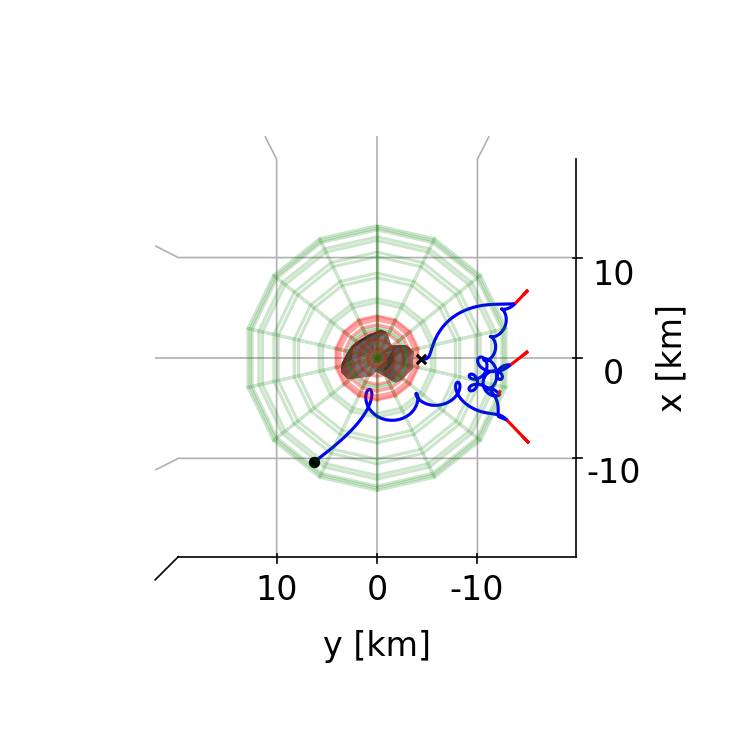

In [185]:
angle = [90,180]

plot_UDP_3D(args, positions, maneuver_positions, maneuver_unit_vectors, True, True, True, True, False, angle, None)

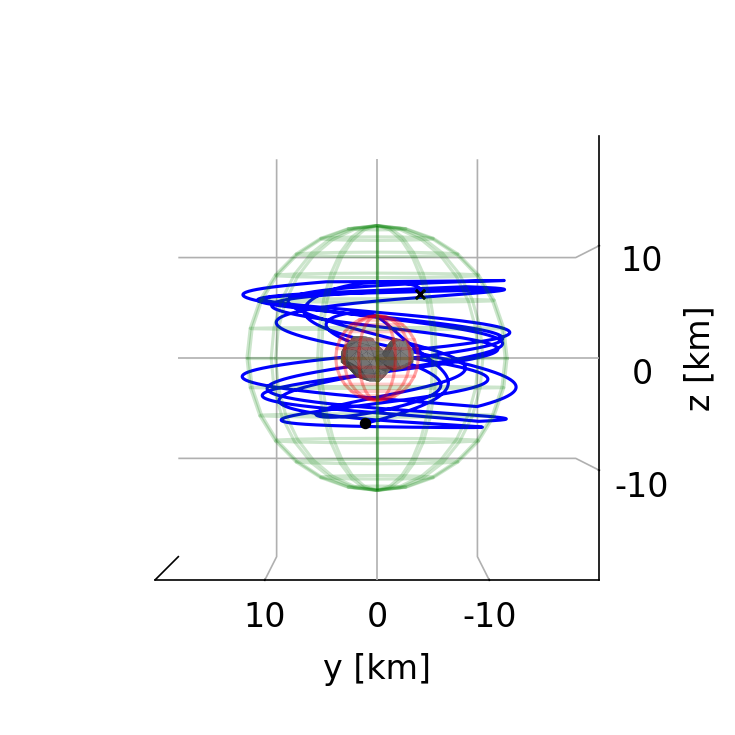

In [187]:
rotated_positions = rotate_point(timesteps, positions, args.body.spin_velocity, args.body.spin_velocity, args.body.quaternion_rotation_objects)
angle = [0,180]
plot_UDP_3D(args, rotated_positions, maneuver_positions, maneuver_unit_vectors, True, True, False, True, False, angle, None)

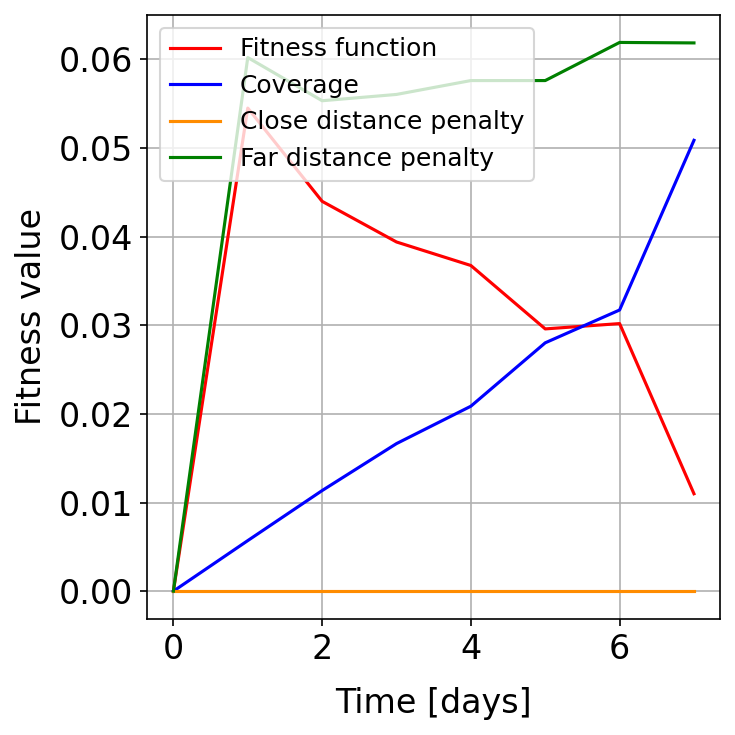

In [198]:
# Fitness over days
# Plot quality of signal over time
args.problem.number_of_spacecrafts = 1

#positions = np.array_split(positions, args.problem.number_of_spacecrafts)
sample_period = int(3600*24/args.problem.measurement_period) #1 day of values in one batch
coverage_list = [0] #zero coverage before mission.

# Compute penalty on initial position:
close_dist_penalty_list = []
far_dist_penalty_list = []
close_dist_penalty_list.append(get_fitness(FitnessFunctions.CloseDistancePenalty, args, positions[:,0], velocities[:,0], timesteps[0]))
far_dist_penalty_list.append(get_fitness(FitnessFunctions.FarDistancePenalty, args, positions[:,0], velocities[:,0], timesteps[0]))

fitness_list = [0]
#fitness_list.append(get_fitness(FitnessFunctions.CoveredSpaceCloseDistancePenaltyFarDistancePenalty, args, positions[:,0], velocities[:,0], timesteps[0]))


# Compute coverage and penatlies evolution over time
quat = args.body.quaternion_rotation_objects

# Multiple spacecraft
if args.problem.number_of_spacecrafts > 1:
    positions_list = np.array_split(positions, args.problem.number_of_spacecrafts, axis=1)
    velocities_list = np.array_split(velocities, args.problem.number_of_spacecrafts, axis=1)

    for i in range(sample_period,len(positions_list[0][0,:])+sample_period, sample_period):   
        print("i: ", i)
        tstep = timesteps[:i]
        for spacecraft_idx in range(0, len(positions_list)):
            if spacecraft_idx == 0:
                pos = positions_list[spacecraft_idx][:, :i]
                vel = velocities_list[spacecraft_idx][:, :i]
            else:
                pos = np.hstack((pos,positions_list[spacecraft_idx][:, :i]))
                vel = np.hstack((vel,velocities_list[spacecraft_idx][:, :i]))

        args.body.quaternion_rotation_objects = None
        coverage_list.append(get_fitness(FitnessFunctions.CoveredSpace, args, pos, vel, tstep))
        close_dist_penalty_list.append(get_fitness(FitnessFunctions.CloseDistancePenalty, args, pos, vel, tstep))
        far_dist_penalty_list.append(get_fitness(FitnessFunctions.FarDistancePenalty, args, pos, vel, tstep))
        fitness_list.append(get_fitness(FitnessFunctions.CoveredSpaceCloseDistancePenaltyFarDistancePenalty, args, pos, vel, tstep))


# Single spacecraft
else:
    for i in range(sample_period,len(positions[0,:])+ sample_period, sample_period):
        pos = positions[:, :i]
        vel = velocities[:, :i]
        tstep = timesteps[:i]
        
        args.body.quaternion_rotation_objects = quat[:i]
        coverage_list.append(get_fitness(FitnessFunctions.CoveredSpace, args, pos, vel, tstep))
        close_dist_penalty_list.append(get_fitness(FitnessFunctions.CloseDistancePenalty, args, pos, vel, timesteps))
        far_dist_penalty_list.append(get_fitness(FitnessFunctions.FarDistancePenalty, args, pos, vel, tstep))
        fitness_list.append(get_fitness(FitnessFunctions.CoveredSpaceCloseDistancePenaltyFarDistancePenalty, args, pos, vel, tstep))


# Generate new time axis
time_axis = np.arange(0, int((args.problem.final_time/3600)/24)+1, 1) #+1 to also include day zero with zero coverage.

fitness_over_time(fitness_list, coverage_list, close_dist_penalty_list, far_dist_penalty_list, time_axis)


In [192]:
print(len(quat))

TypeError: object of type 'NoneType' has no len()

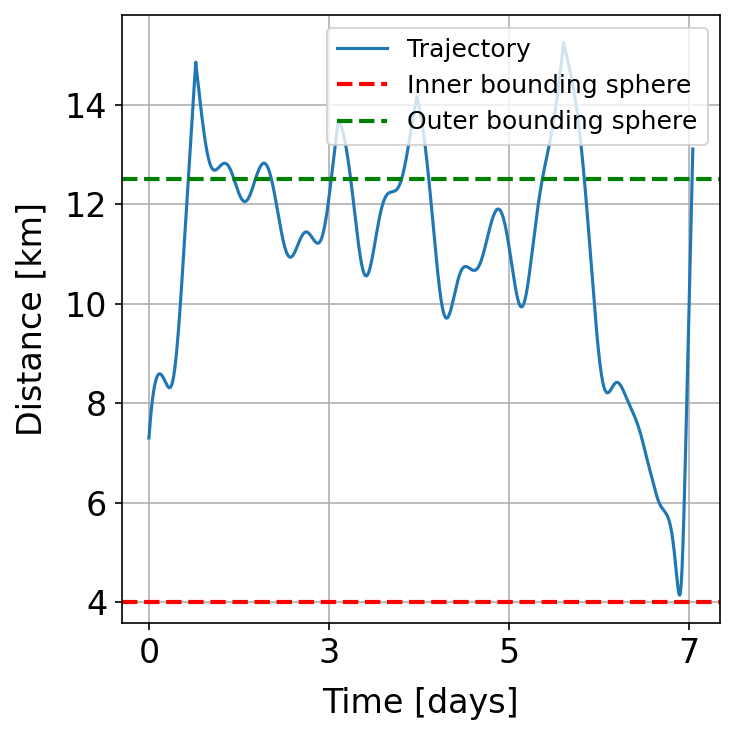

In [199]:
# Distance deviation over days
distance_deviation_over_time(args.problem.number_of_spacecrafts, 
                             args.problem.radius_inner_bounding_sphere, 
                             args.problem.radius_outer_bounding_sphere, positions, timesteps)

289


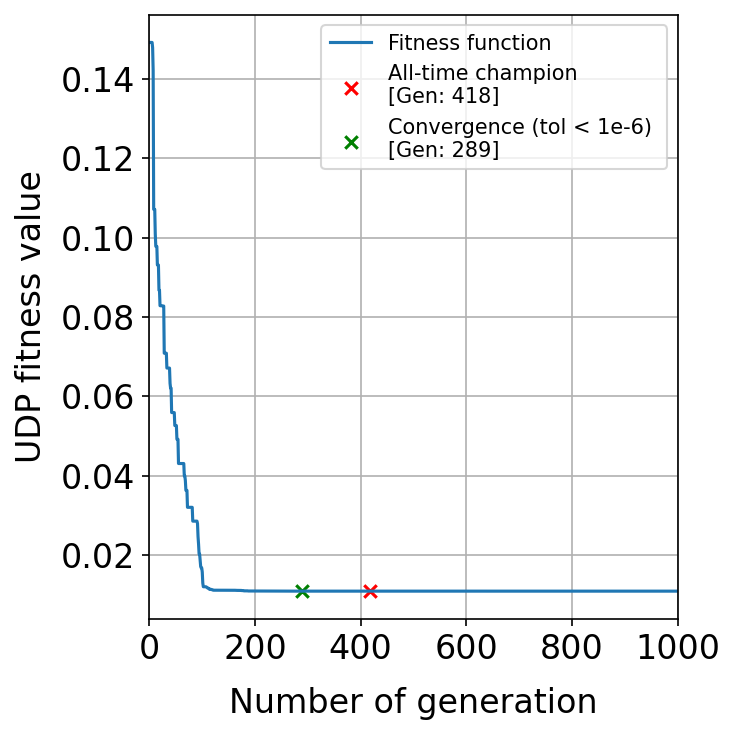

In [201]:
# Plot fitness over generations
fitness_list = np.genfromtxt('Local_new_gaco_param_1S_4M_fitness_list.csv', delimiter=',')
n_generations = 1000
fitness_over_generations(fitness_list, n_generations)

In [14]:
args.problem.number_of_spacecrafts = 4

In [93]:
position_list =  np.array_split(positions,args.problem.number_of_spacecrafts, axis=1)
maneuver_positions_list =  np.array_split(maneuver_positions,args.problem.number_of_spacecrafts, axis=1)
maneuver_unit_vectors_list =  np.array_split(maneuver_unit_vectors,args.problem.number_of_spacecrafts, axis=1)

# split arrays: 
#Spacecraft 1-2
positions_spaceraft_one_and_two = np.hstack((position_list[0], position_list[1]))
maneuver_positions_spaceraft_one_and_two = np.hstack((maneuver_positions_list[0], maneuver_positions_list[1]))
maneuver_unit_vectors_one_and_two = np.hstack((maneuver_unit_vectors_list[0], maneuver_unit_vectors_list[1]))

#Spacecraft 3-4
positions_spaceraft_three_and_four = np.hstack((position_list[2], position_list[3]))
maneuver_positions_spaceraft_three_and_four = np.hstack((maneuver_positions_list[2], maneuver_positions_list[3]))
maneuver_unit_vectors_three_and_four = np.hstack((maneuver_unit_vectors_list[2], maneuver_unit_vectors_list[3]))

args.problem.number_of_spacecrafts = 2 

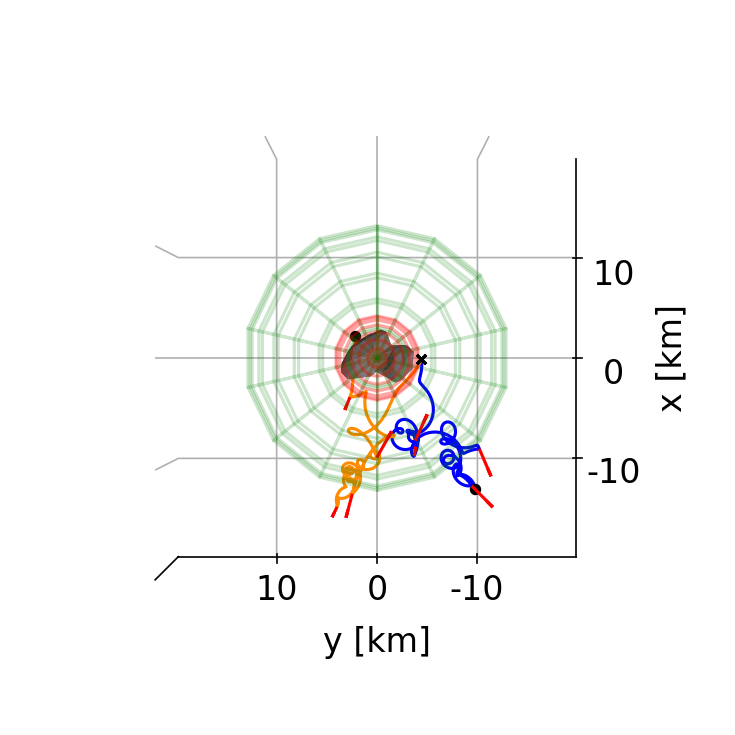

In [108]:
angle = [90,180]
plot_UDP_3D(args, positions_spaceraft_one_and_two, maneuver_positions_spaceraft_one_and_two, maneuver_unit_vectors_one_and_two, True, True, True, True, False, angle, None)

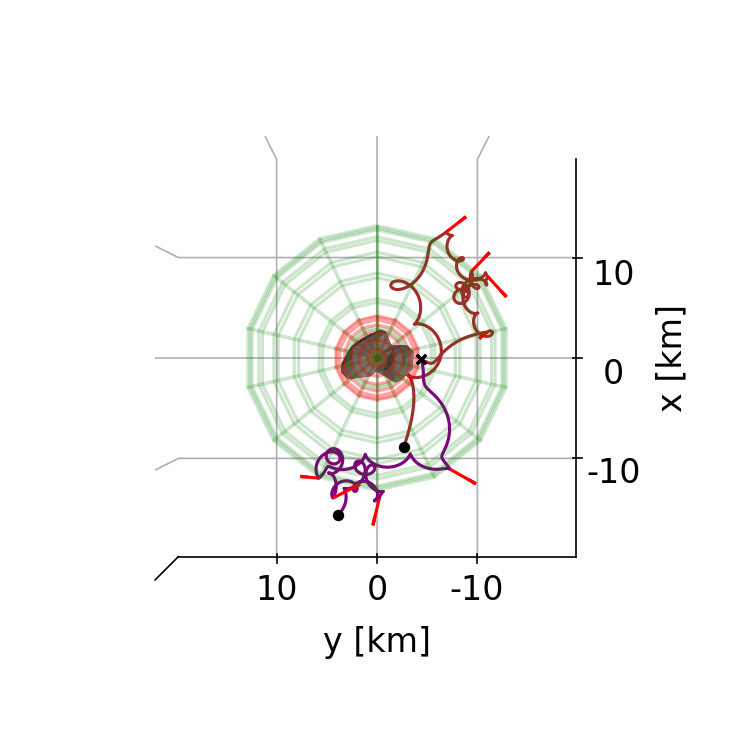

In [109]:
angle = [90,180]
plot_UDP_3D(args, positions_spaceraft_three_and_four, maneuver_positions_spaceraft_three_and_four, maneuver_unit_vectors_three_and_four, True, True, True, True, False, angle, None)

In [110]:
rotated_positions = rotate_point(timesteps, positions, args.body.spin_velocity, args.body.spin_velocity, args.body.quaternion_rotation_objects)
args.problem.number_of_spacecrafts = 4

position_list =  np.array_split(rotated_positions,args.problem.number_of_spacecrafts, axis=1)
maneuver_positions_list =  np.array_split(maneuver_positions,args.problem.number_of_spacecrafts, axis=1)
maneuver_unit_vectors_list =  np.array_split(maneuver_unit_vectors,args.problem.number_of_spacecrafts, axis=1)

# split arrays: 
#Spacecraft 1-2
positions_spaceraft_one_and_two = np.hstack((position_list[0], position_list[1]))
maneuver_positions_spaceraft_one_and_two = np.hstack((maneuver_positions_list[0], maneuver_positions_list[1]))
maneuver_unit_vectors_one_and_two = np.hstack((maneuver_unit_vectors_list[0], maneuver_unit_vectors_list[1]))

#Spacecraft 3-4
positions_spaceraft_three_and_four = np.hstack((position_list[2], position_list[3]))
maneuver_positions_spaceraft_three_and_four = np.hstack((maneuver_positions_list[2], maneuver_positions_list[3]))
maneuver_unit_vectors_three_and_four = np.hstack((maneuver_unit_vectors_list[2], maneuver_unit_vectors_list[3]))

args.problem.number_of_spacecrafts = 2 

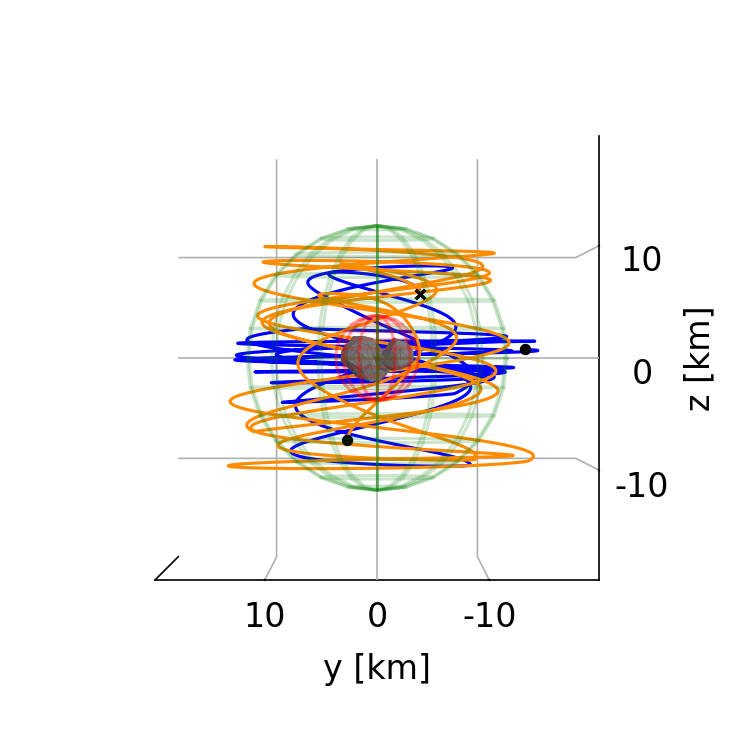

In [116]:
angle = [0,180]
plot_UDP_3D(args, positions_spaceraft_one_and_two, maneuver_positions_spaceraft_one_and_two, maneuver_unit_vectors_one_and_two, True, True, False, True, False, angle, None)

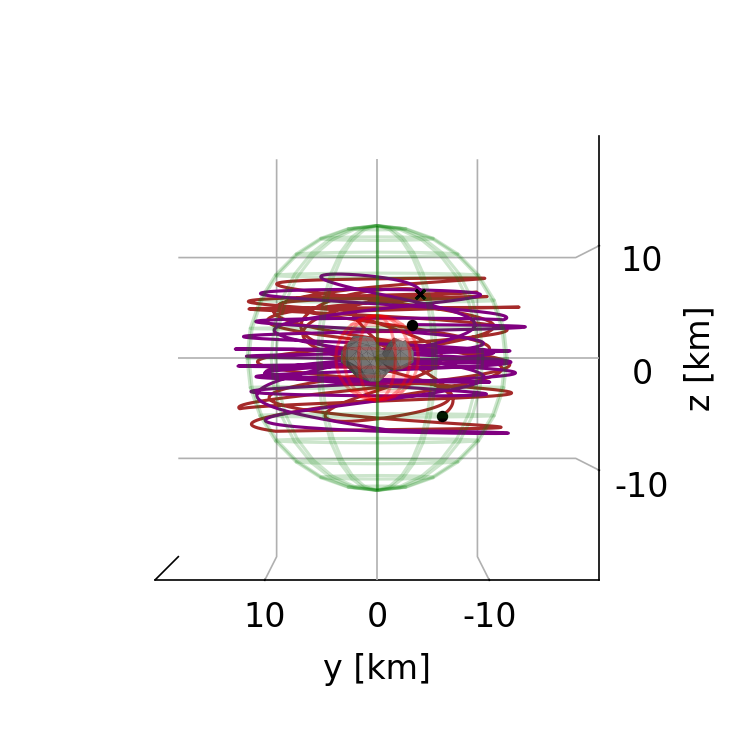

In [117]:
angle = [0,180]
plot_UDP_3D(args, positions_spaceraft_three_and_four, maneuver_positions_spaceraft_three_and_four, maneuver_unit_vectors_three_and_four, True, True, False, True, False, angle, None)

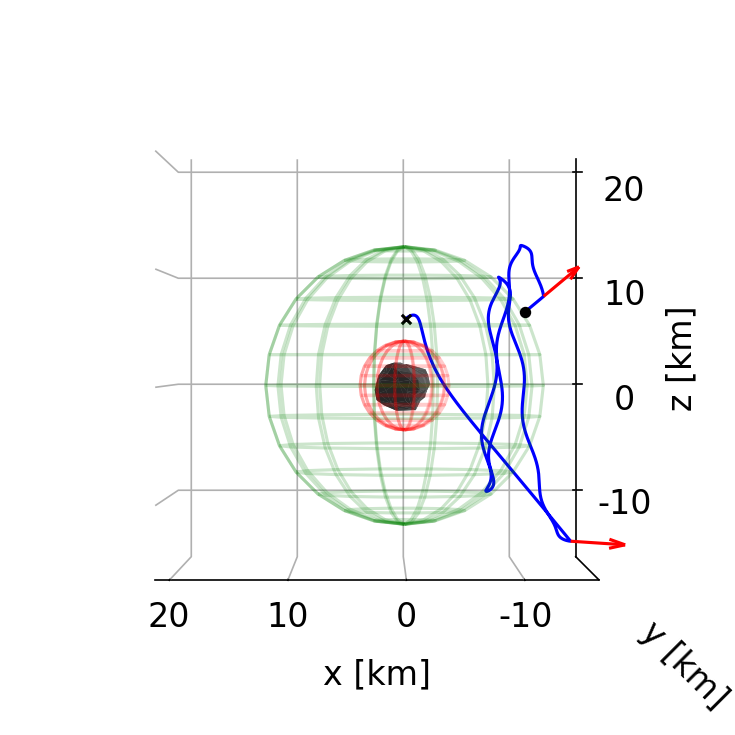

In [20]:
# 2 Maneuvers

angle = [0,90]
plot_UDP_3D(args, positions, maneuver_positions, maneuver_unit_vectors, True, True, True, True, False, angle, None)

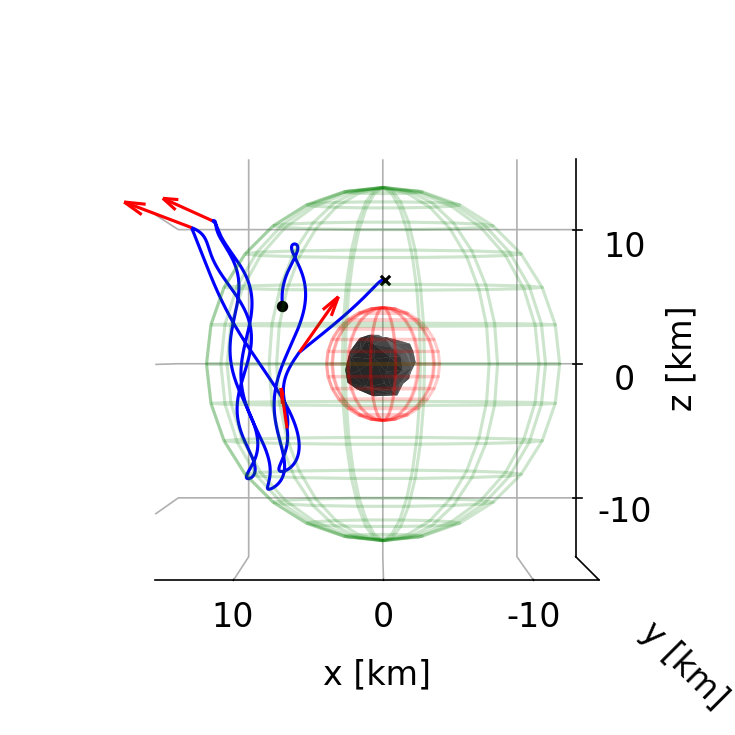

In [24]:
# 4 Maneuvers

angle = [0,90]
plot_UDP_3D(args, positions, maneuver_positions, maneuver_unit_vectors, True, True, True, True, False, angle, None)

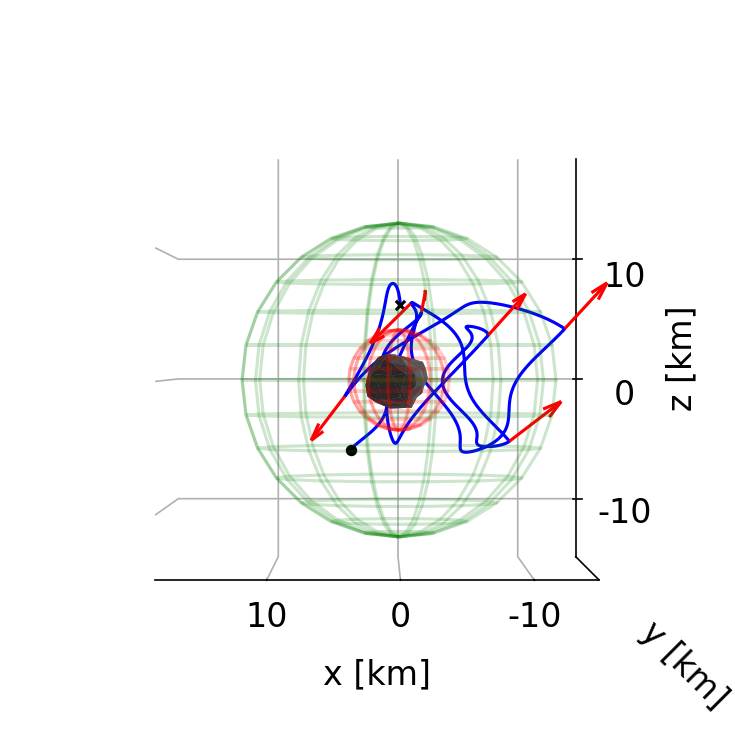

In [28]:
# 6 Maneuvers

angle = [0,90]
plot_UDP_3D(args, positions, maneuver_positions, maneuver_unit_vectors, True, True, True, True, False, angle, None)

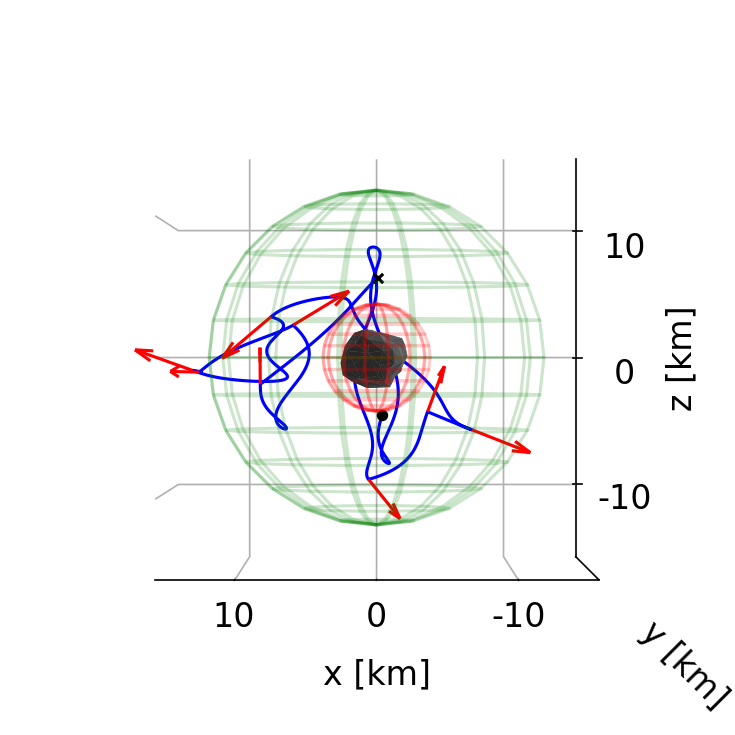

In [32]:
# 8 Maneuvers

angle = [0,90]
plot_UDP_3D(args, positions, maneuver_positions, maneuver_unit_vectors, True, True, True, True, False, angle, None)

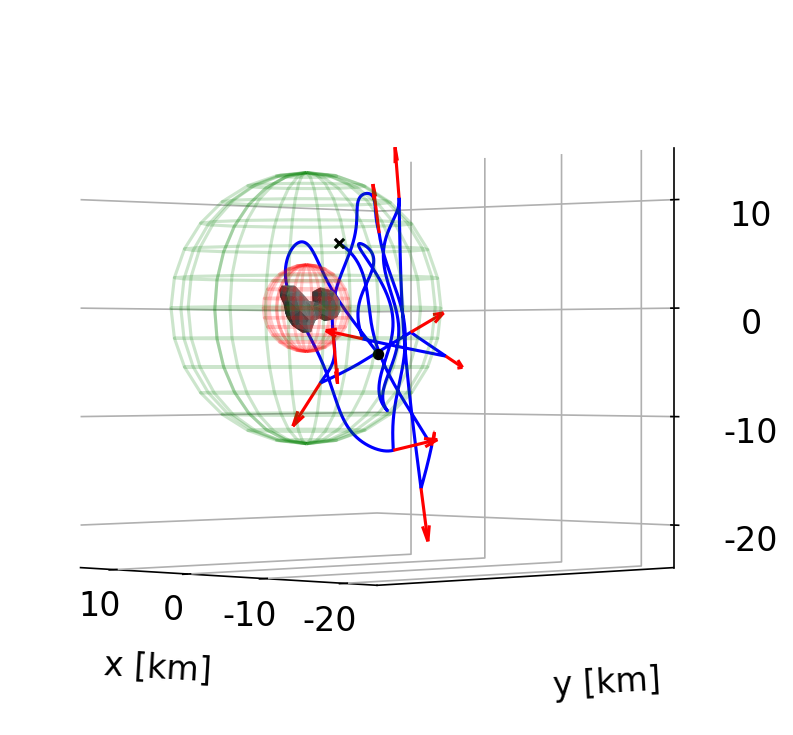

In [39]:
# 10 Maneuvers

angle = [0,(90+45)]
plot_UDP_3D(args, positions, maneuver_positions, maneuver_unit_vectors, True, True, True, True, False, angle, None)

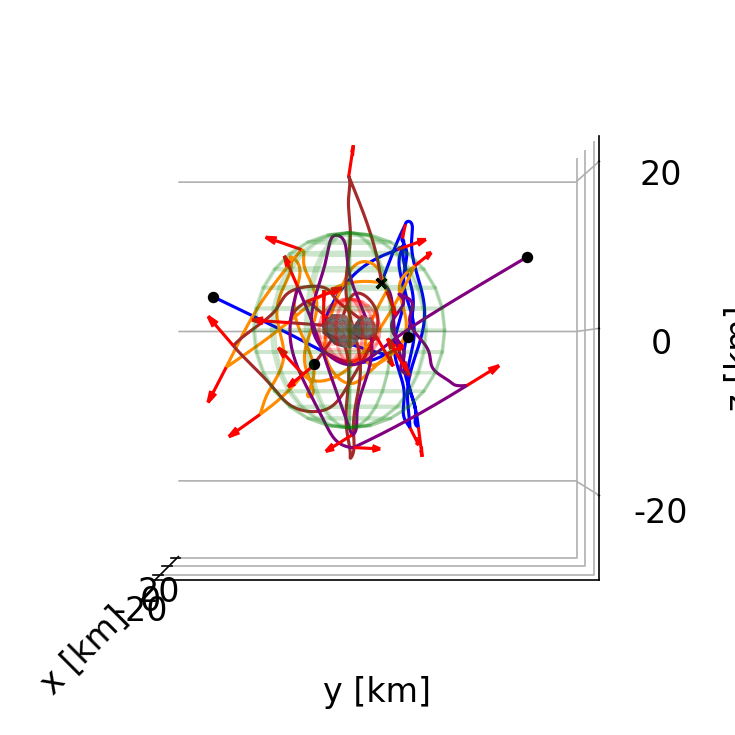

In [9]:
# 4 spacecraft with 6 maneuvers each
angle = [0,180]
plot_UDP_3D(args, positions, maneuver_positions, maneuver_unit_vectors, True, True, True, True, False, angle, None)

In [28]:
args = setup_parameters()

TomlDecodeError: invalid literal for int() with base 0: 'pi/2' (line 50 column 1 char 3501)

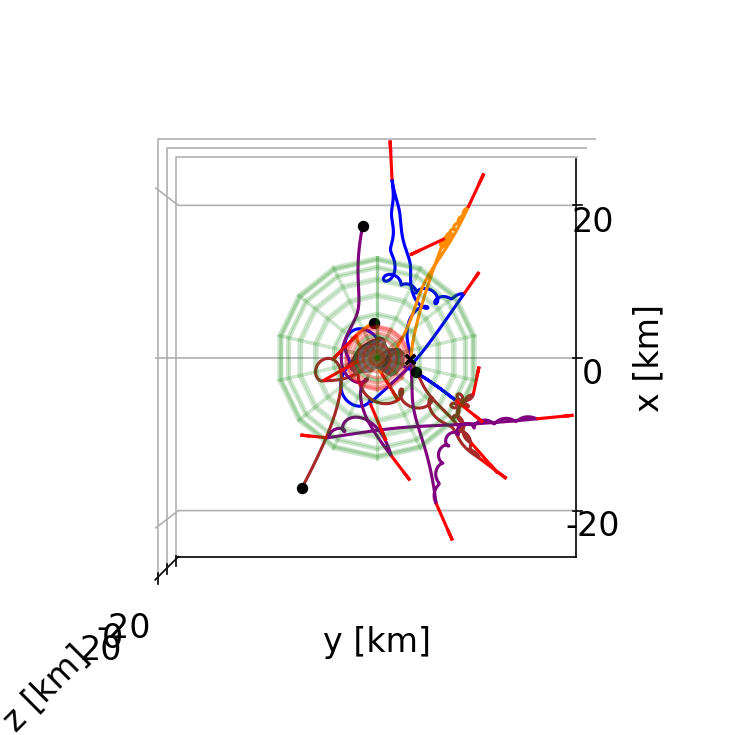

In [7]:
angle = [90,180]
plot_UDP_3D(args, positions, maneuver_positions, maneuver_unit_vectors, True, True, True, True, False, angle, None)

In [64]:
position_list =  np.array_split(positions,args.problem.number_of_spacecrafts, axis=1)
maneuver_positions_list =  np.array_split(maneuver_positions,args.problem.number_of_spacecrafts, axis=1)
maneuver_unit_vectors_list =  np.array_split(maneuver_unit_vectors,args.problem.number_of_spacecrafts, axis=1)

# split arrays: 
#Spacecraft 1-2
positions_spaceraft_one_and_two = np.hstack((position_list[0], position_list[1]))
maneuver_positions_spaceraft_one_and_two = np.hstack((maneuver_positions_list[0], maneuver_positions_list[1]))
maneuver_unit_vectors_one_and_two = np.hstack((maneuver_unit_vectors_list[0], maneuver_unit_vectors_list[1]))

#Spacecraft 3-4
positions_spaceraft_three_and_four = np.hstack((position_list[2], position_list[3]))
maneuver_positions_spaceraft_three_and_four = np.hstack((maneuver_positions_list[2], maneuver_positions_list[3]))
maneuver_unit_vectors_three_and_four = np.hstack((maneuver_unit_vectors_list[2], maneuver_unit_vectors_list[3]))

args.problem.number_of_spacecrafts = 1 

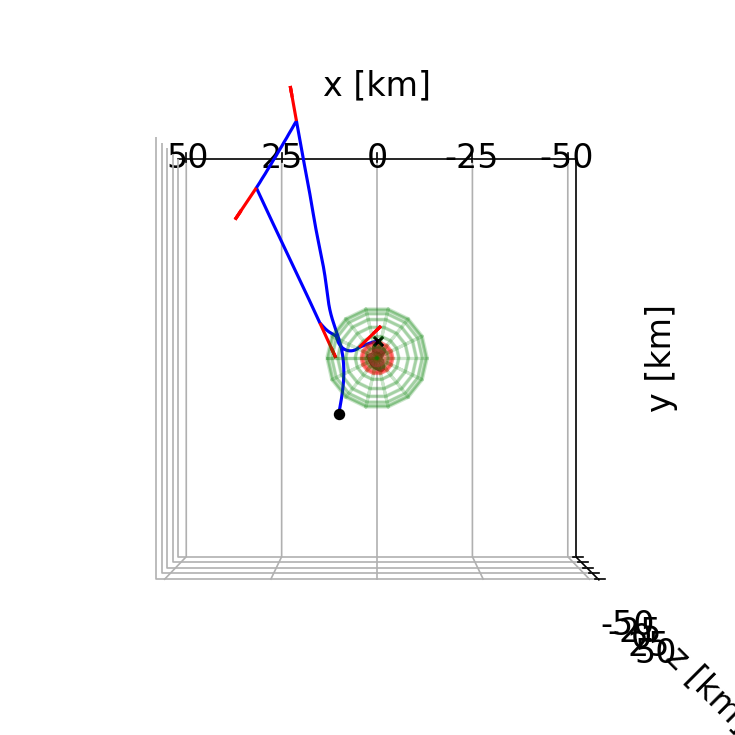

In [66]:
#Individual plot - Spacecraft 1:
angle = [90,90]
plot_UDP_3D(args, position_list[0], maneuver_positions_list[0], maneuver_unit_vectors_list[0], True, True, True, True, False, angle, None)

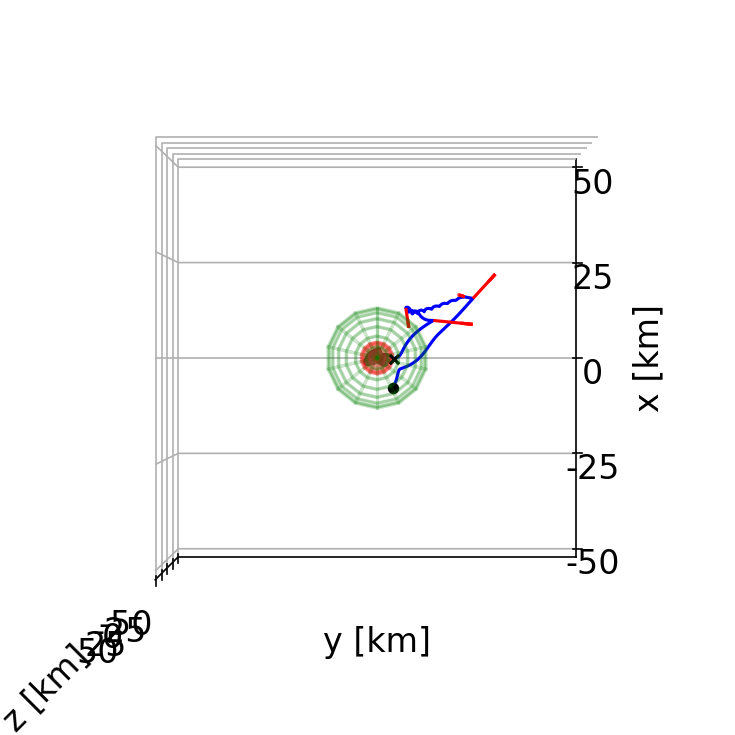

In [69]:
#Individual plot - Spacecraft 2:
angle = [90,180]
plot_UDP_3D(args, position_list[1], maneuver_positions_list[1], maneuver_unit_vectors_list[1], True, True, True, True, False, angle, None)

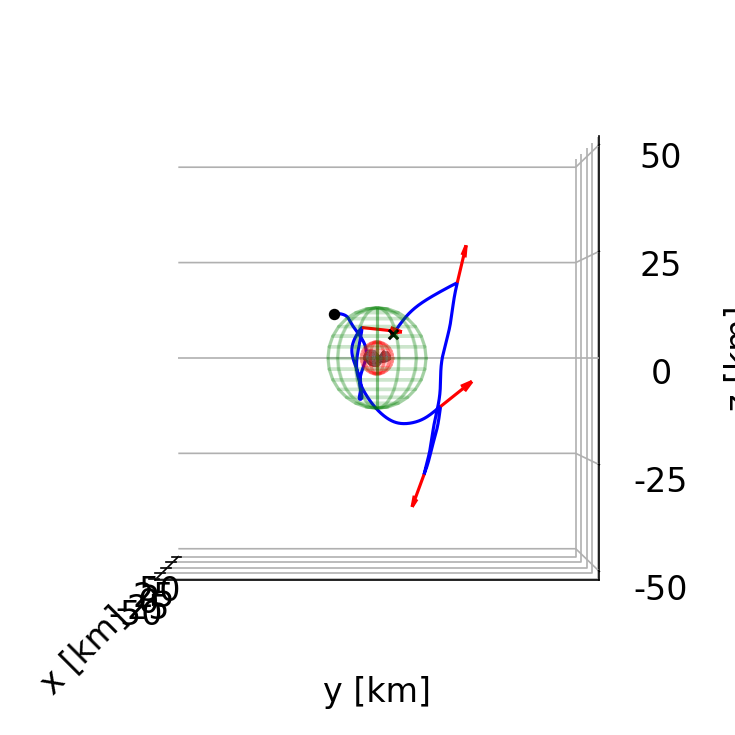

In [71]:
#Individual plot - Spacecraft 3:
angle = [0,180]
plot_UDP_3D(args, position_list[2], maneuver_positions_list[2], maneuver_unit_vectors_list[2], True, True, True, True, False, angle, None)

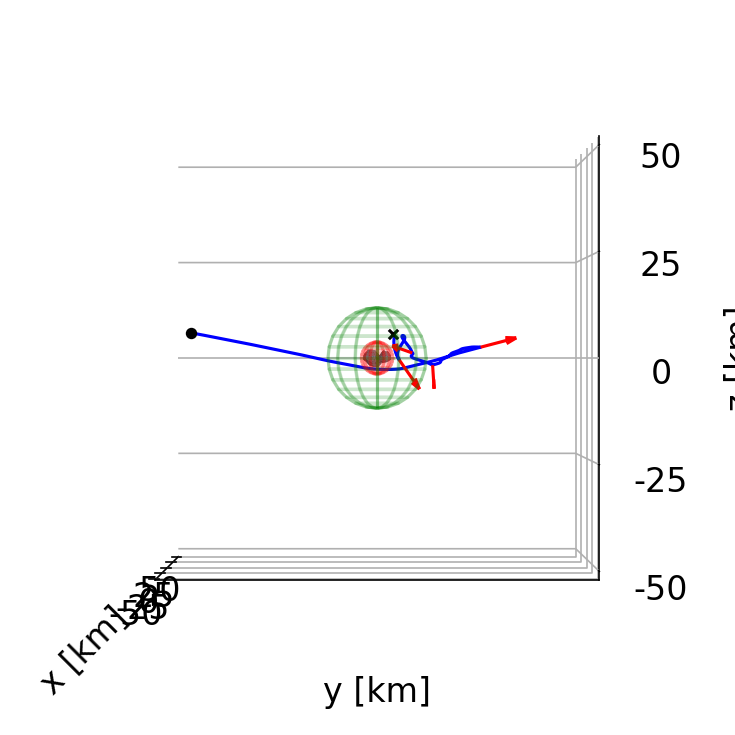

In [73]:
#Individual plot - Spacecraft 4:
angle = [0,180]
plot_UDP_3D(args, position_list[3], maneuver_positions_list[3], maneuver_unit_vectors_list[3], True, True, True, True, False, angle, None)